In [ ]:
!pip install simpy

In [ ]:
import simpy
import numpy as np
from collections import defaultdict

class PortSimulator:
    def __init__(self, config):
        self.env = simpy.Environment()
        self.config = config
        self.metrics = {
            'wait_times': [],
            'queue_lengths': [],
            'utilization_time': 0.0,
            'congestion_time': 0,
            'last_event': 0.0
        }
        self.docks = simpy.Resource(self.env, capacity=config['dock_capacity'])

    def truck_handler(self, truck_id):
        arrival = self.env.now
        with self.docks.request() as req:
            yield req

            # Record waiting time
            wait = self.env.now - arrival
            self.metrics['wait_times'].append(wait)

            # Check for congestion
            if len(self.docks.queue) > self.config['dock_capacity']:
                self.metrics['congestion_time'] += 1

            # Update utilization
            self._update_utilization()

            # Process service
            yield self.env.timeout(np.random.exponential(1/self.config['service_rate']))
            self.metrics['last_event'] = self.env.now

    def _update_utilization(self):
        if self.docks.count > 0:
            elapsed = self.env.now - self.metrics['last_event']
            self.metrics['utilization_time'] += elapsed * self.docks.count
        self.metrics['last_event'] = self.env.now

    def generate_arrivals(self):
        for i in range(self.config['total_trucks']):
            yield self.env.timeout(np.random.exponential(1/self.config['arrival_rate']))
            self.env.process(self.truck_handler(i))
            self.metrics['queue_lengths'].append(len(self.docks.queue))

    def run_simulation(self):
        self.env.process(self.generate_arrivals())
        self.env.run()

        return {
            'avg_wait': np.mean(self.metrics['wait_times']),
            'utilization': self.metrics['utilization_time'] / (self.config['dock_capacity'] * self.env.now),
            'congestion_prob': self.metrics['congestion_time'] / len(self.metrics['queue_lengths']),
            'queue_dist': self.metrics['queue_lengths']
        }

# Simulation configurations
SCENARIOS = [
    {'service_rate': 0.25, 'total_trucks': 500, 'arrival_rate': 4.0, 'dock_capacity': 5},
    {'service_rate': 0.33, 'total_trucks': 600, 'arrival_rate': 5.0, 'dock_capacity': 4},
    {'service_rate': 0.20, 'total_trucks': 700, 'arrival_rate': 6.0, 'dock_capacity': 3},
    {'service_rate': 0.25, 'total_trucks': 800, 'arrival_rate': 4.5, 'dock_capacity': 4},
    {'service_rate': 0.33, 'total_trucks': 1000, 'arrival_rate': 5.5, 'dock_capacity': 6}
]

# Execute simulations
for i, config in enumerate(SCENARIOS, 1):
    print(f"Running Scenario {i}")
    simulator = PortSimulator(config)
    results = simulator.run_simulation()
    print(f"Results - Avg Wait: {results['avg_wait']:.2f}, "
          f"Utilization: {results['utilization']:.2f}, "
          f"Congestion: {results['congestion_prob']:.2f}")

Running Scenario 1
Results - Avg Wait: 132.53, Utilization: 0.00, Congestion: 0.96
Running Scenario 2
Results - Avg Wait: 165.21, Utilization: 0.00, Congestion: 0.98
Running Scenario 3
Results - Avg Wait: 496.07, Utilization: 0.00, Congestion: 0.99
Running Scenario 4
Results - Avg Wait: 293.56, Utilization: 0.00, Congestion: 0.99
Running Scenario 5
Results - Avg Wait: 175.30, Utilization: 0.00, Congestion: 0.98


Running 24-hour port simulation with Bayesian λ estimation...

Utilization Verification:
- Hourly averages: [np.float64(0.7575757575757576), np.float64(0.925), np.float64(0.9907407407407407), np.float64(0.9743589743589743), np.float64(0.9083333333333333), np.float64(0.9910714285714286), np.float64(0.9423076923076923), np.float64(0.6833333333333333), np.float64(0.7333333333333333), np.float64(0.9485294117647058), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.89), np.float64(0.8951612903225806), np.float64(1.0), np.float64(0.9044117647058824), np.float64(0.8387096774193549), np.float64(0.8854166666666666), np.float64(0.8166666666666667), np.float64(0.9662162162162162), np.float64(0.9112903225806451), np.float64(0.8333333333333334), np.float64(0.9932432432432432)]
- Calculated utilization: 88.6%

Key Metrics:
Average wait time: 0.07 hours
Dock utilization: 88.6%
Overall congestion probability: 0.0%
Congestion occurred in these hours: []

Final Bayesian Estimate:
- Poster

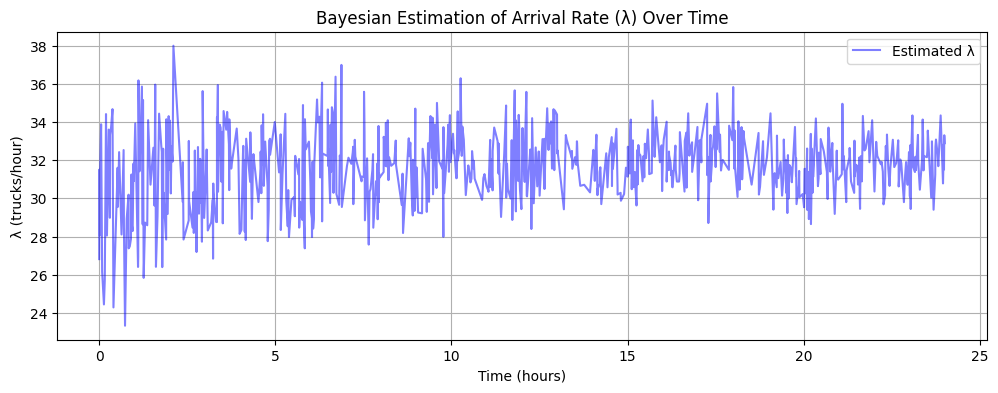

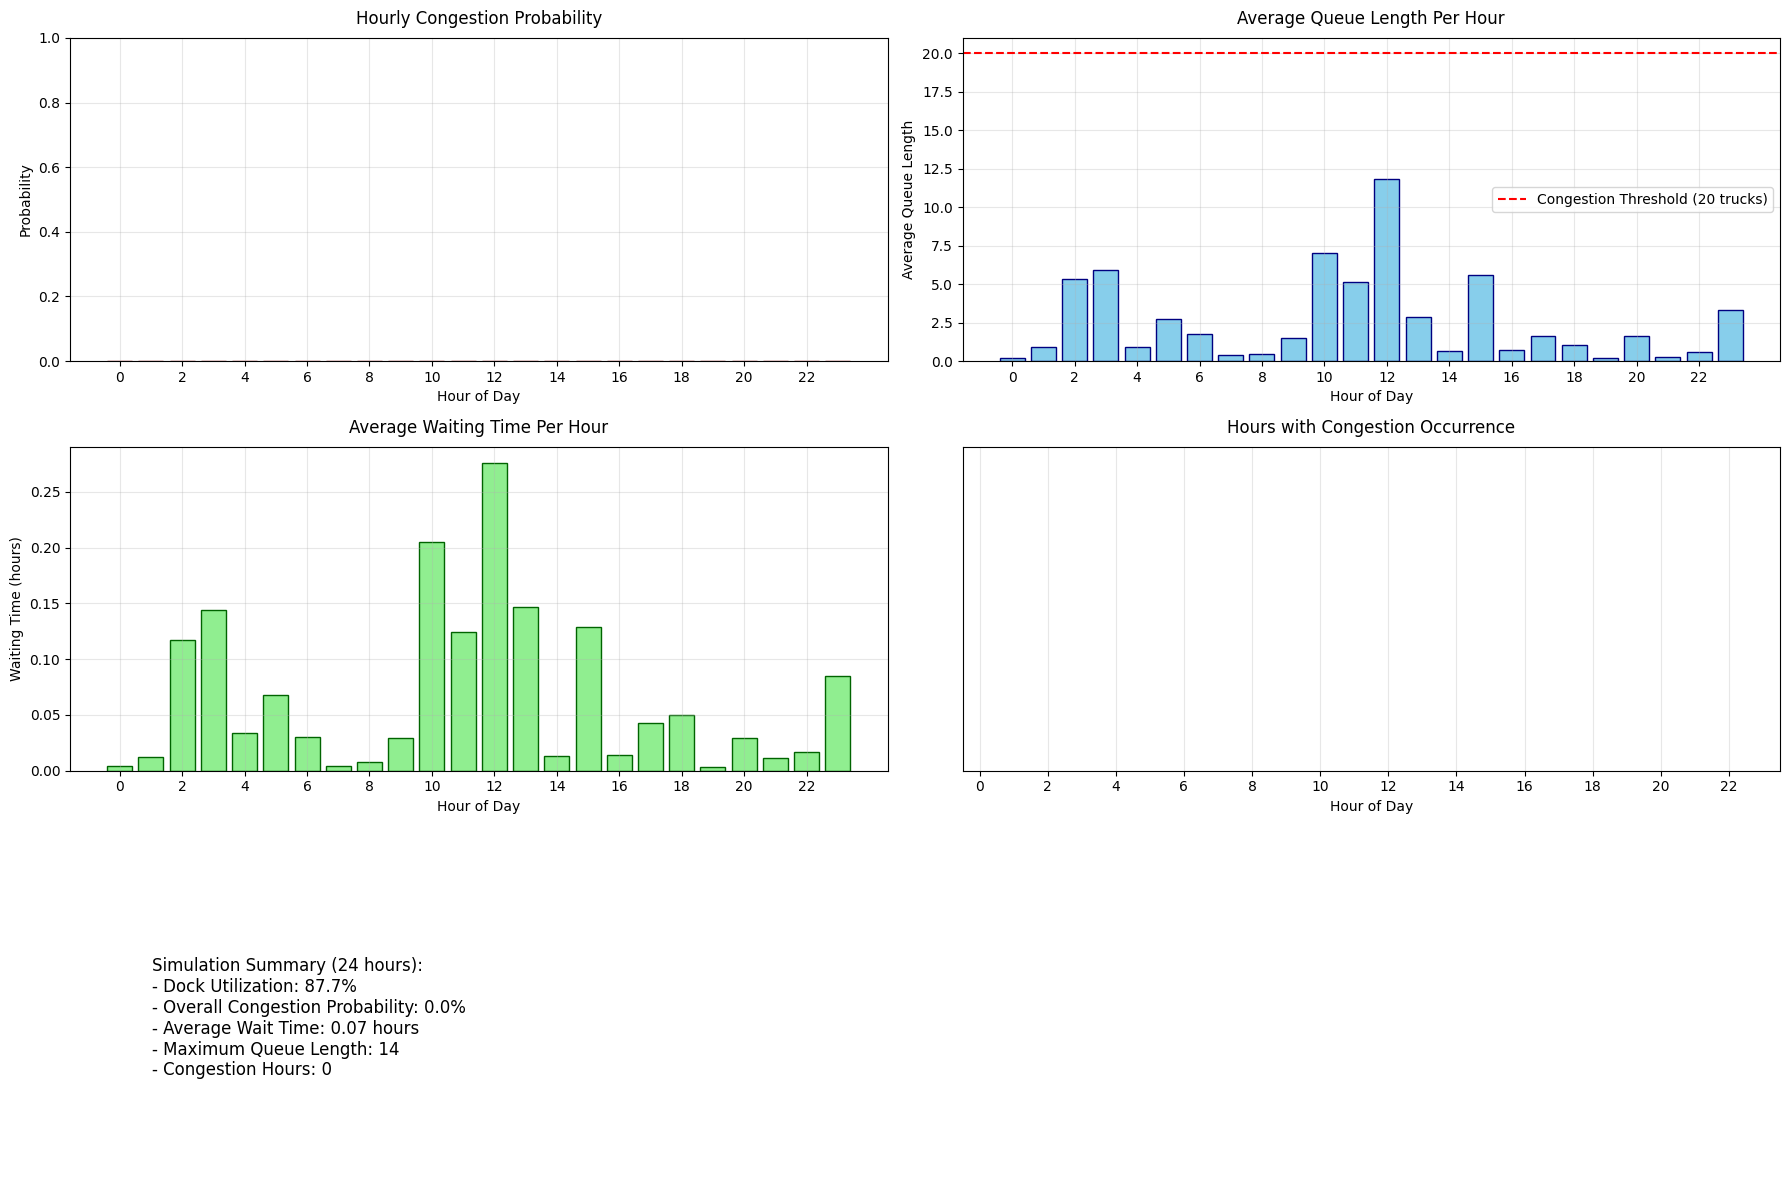

In [ ]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats
from matplotlib.gridspec import GridSpec

class DynamicDocks:
    """Wrapper for dynamic dock capacity"""
    def __init__(self, env, initial_capacity):
        self.env = env
        self.capacity = initial_capacity
        self.resource = simpy.Resource(env, capacity=initial_capacity)

    def change_capacity(self, new_capacity):
        """Create a new resource with updated capacity"""
        self.capacity = new_capacity
        self.resource = simpy.Resource(self.env, capacity=new_capacity)
        return self.resource

class PortSimulator:
    def __init__(self, config):
        self.env = simpy.Environment()
        self.config = config
        self.metrics = {
            'wait_times': [],
            'queue_lengths': [],
            'hourly_congestion': [0] * 24,
            'hourly_counts': [0] * 24,
            'hourly_wait_times': [[] for _ in range(24)],
            'utilization_time': 0.0,
            'last_event': 0.0,
            'congestion_hours': set(),
            'interarrival_times': [],
            'active_docks': config['dock_capacity'],
            'capacity_changes': [(0, config['dock_capacity'])],
            'estimated_lambda': [],
            'hourly_busy': [[] for _ in range(24)]  # Track busy docks per hour
        }
        self.docks = DynamicDocks(self.env, config['dock_capacity'])

        # Bayesian parameters (Gamma prior)
        self.alpha = 60  # Prior shape (pseudo-count of arrivals)
        self.beta = 2    # Prior rate (pseudo-observation time)
        self.last_arrival_time = 0  # Track time between arrivals

        # Schedule dock changes
        self.env.process(self.manage_dock_schedule())

    def manage_dock_schedule(self):
        yield self.env.timeout(17)  # Reduce docks at 5 PM
        new_capacity = self.docks.capacity - 1
        self.docks.change_capacity(new_capacity)
        self.metrics['active_docks'] = new_capacity
        self.metrics['capacity_changes'].append((self.env.now, new_capacity))

        yield self.env.timeout(1)   # Restore at 6 PM
        new_capacity = self.docks.capacity + 1
        self.docks.change_capacity(new_capacity)
        self.metrics['active_docks'] = new_capacity
        self.metrics['capacity_changes'].append((self.env.now, new_capacity))

    def truck_handler(self, truck_id):
        arrival = self.env.now
        with self.docks.resource.request() as req:
            # Record queue length at arrival
            queue_length = len(self.docks.resource.queue)
            self.metrics['queue_lengths'].append((self.env.now, queue_length))
            yield req

            current_hour = int(self.env.now)
            if current_hour >= 24:
                return

            # Record processing start
            wait = self.env.now - arrival
            self.metrics['wait_times'].append(wait)
            self.metrics['hourly_wait_times'][current_hour].append(wait)
            self.metrics['hourly_counts'][current_hour] += 1

            # Track busy docks
            busy_docks = self.docks.resource.count
            self.metrics['hourly_busy'][current_hour].append(busy_docks)
            self._update_utilization()

            if queue_length > self.config['congestion_threshold']:
                self.metrics['hourly_congestion'][current_hour] += 1
                self.metrics['congestion_hours'].add(current_hour)

            # Simulate unloading
            service_time = np.random.exponential(1 / self.config['service_rate'])
            yield self.env.timeout(service_time)
            self._update_utilization()

    def _update_utilization(self):
        """Track dock utilization over time"""
        now = self.env.now
        elapsed = now - self.metrics['last_event']

        # Multiply busy docks by time elapsed
        busy_docks = self.docks.resource.count
        self.metrics['utilization_time'] += elapsed * busy_docks
        self.metrics['last_event'] = now

    def calculate_utilization(self):
        """Calculate accurate utilization percentage"""
        total_dock_hours = 0
        last_time = 0
        last_capacity = self.config['dock_capacity']

        # Account for capacity changes
        for time, new_capacity in self.metrics['capacity_changes']:
            total_dock_hours += (time - last_time) * last_capacity
            last_time = time
            last_capacity = new_capacity

        # Add remaining time
        total_dock_hours += (24 - last_time) * last_capacity

        return self.metrics['utilization_time'] / total_dock_hours

    def generate_arrivals(self):
        """Generate trucks using Bayesian-estimated λ"""
        while self.env.now < 24:
            # Sample λ from current Gamma posterior
            current_lambda = np.random.gamma(self.alpha, 1/self.beta)
            self.metrics['estimated_lambda'].append((self.env.now, current_lambda))

            # Generate next arrival
            interarrival = np.random.exponential(1 / current_lambda)
            yield self.env.timeout(interarrival)

            # Update Bayesian parameters after each arrival
            if self.last_arrival_time > 0:  # Skip first update (no prior interval)
                time_since_last = self.env.now - self.last_arrival_time
                self.alpha += 1  # Observed 1 new arrival
                self.beta += time_since_last  # Add observed time interval

            self.last_arrival_time = self.env.now
            truck_id = len(self.metrics['wait_times'])
            self.env.process(self.truck_handler(truck_id))

    def run_simulation(self):
        """Run the simulation for 24 hours"""
        self.env.process(self.generate_arrivals())
        self.env.run(until=24)

        # Verify utilization calculations
        self._verify_utilization()
        return self.metrics

    def _verify_utilization(self):
        """Sanity check utilization calculations"""
        hourly_util = []
        for hour in range(24):
            if not self.metrics['hourly_busy'][hour]:
                hourly_util.append(0)
                continue

            # Get capacity during this hour
            capacity = next((cap for t,cap in reversed(self.metrics['capacity_changes']) if t <= hour),
                          self.config['dock_capacity'])

            avg_busy = np.mean(self.metrics['hourly_busy'][hour])
            hourly_util.append(avg_busy / capacity)

        print("\nUtilization Verification:")
        print(f"- Hourly averages: {hourly_util}")
        print(f"- Calculated utilization: {self.calculate_utilization():.1%}")

def visualize_all_results(metrics, config):
    plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 2, figure=plt.gcf())

    # Plot 1: Hourly Congestion Probability
    ax1 = plt.subplot(gs[0, 0])
    hours = range(24)
    congestion_probs = [
        metrics['hourly_congestion'][h] / metrics['hourly_counts'][h]
        if metrics['hourly_counts'][h] > 0 else 0
        for h in hours
    ]
    ax1.bar(hours, congestion_probs, color='salmon', edgecolor='darkred')
    ax1.set_title('Hourly Congestion Probability', fontsize=12, pad=10)
    ax1.set_xlabel('Hour of Day', fontsize=10)
    ax1.set_ylabel('Probability', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 2))
    ax1.set_ylim(0, 1)

    # Plot 2: Average Queue Length Per Hour
    ax2 = plt.subplot(gs[0, 1])
    hourly_queue_lengths = defaultdict(list)
    for time, length in metrics['queue_lengths']:
        hour = int(time)
        if hour < 24:
            hourly_queue_lengths[hour].append(length)

    avg_lengths = [
        np.mean(hourly_queue_lengths[h]) if h in hourly_queue_lengths else 0
        for h in range(24)
    ]

    ax2.bar(hours, avg_lengths, color='skyblue', edgecolor='navy')
    ax2.axhline(y=config['congestion_threshold'], color='red', linestyle='--',
               label=f'Congestion Threshold ({config["congestion_threshold"]} trucks)')
    ax2.set_title('Average Queue Length Per Hour', fontsize=12, pad=10)
    ax2.set_xlabel('Hour of Day', fontsize=10)
    ax2.set_ylabel('Average Queue Length', fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 24, 2))

    # Plot 3: Average Waiting Time Per Hour
    ax3 = plt.subplot(gs[1, 0])
    avg_wait_times = [
        np.mean(metrics['hourly_wait_times'][h]) if metrics['hourly_wait_times'][h] else 0
        for h in hours
    ]

    ax3.bar(hours, avg_wait_times, color='lightgreen', edgecolor='darkgreen')
    ax3.set_title('Average Waiting Time Per Hour', fontsize=12, pad=10)
    ax3.set_xlabel('Hour of Day', fontsize=10)
    ax3.set_ylabel('Waiting Time (hours)', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, 24, 2))

    # # Plot 4: Queue Length Over Time
    # ax4 = plt.subplot(gs[1, 1])
    # if metrics['queue_lengths']:
    #     times, lengths = zip(*metrics['queue_lengths'])
    #     ax4.plot(times, lengths, color='purple', alpha=0.7, linewidth=1)
    # ax4.set_title('Queue Length Over Time', fontsize=12, pad=10)
    # ax4.set_xlabel('Time (hours)', fontsize=10)
    # ax4.set_ylabel('Trucks in Queue', fontsize=10)
    # ax4.grid(True, alpha=0.3)
    # ax4.set_xlim(0, 24)

    # Plot 5: Congestion Hours
    ax4 = plt.subplot(gs[1, 1])
    congestion_hours = sorted(metrics['congestion_hours'])
    ax4.bar(congestion_hours, [1]*len(congestion_hours), color='red', width=0.4)
    ax4.set_title('Hours with Congestion Occurrence', fontsize=12, pad=10)
    ax4.set_xlabel('Hour of Day', fontsize=10)
    ax4.set_yticks([])
    ax4.grid(True, alpha=0.3, axis='x')
    ax4.set_xlim(-0.5, 23.5)
    ax4.set_xticks(range(0, 24, 2))

    # Plot 6: Utilization and Summary
    ax5 = plt.subplot(gs[2, 0])
    utilization = metrics['utilization_time'] / (config['dock_capacity'] * 24)
    congestion_prob = sum(metrics['hourly_congestion']) / sum(metrics['hourly_counts']) if sum(metrics['hourly_counts']) > 0 else 0

    summary_text = (
        f"Simulation Summary (24 hours):\n"
        f"- Dock Utilization: {utilization:.1%}\n"
        f"- Overall Congestion Probability: {congestion_prob:.1%}\n"
        f"- Average Wait Time: {np.mean(metrics['wait_times']):.2f} hours\n"
        f"- Maximum Queue Length: {max(length for _, length in metrics['queue_lengths'])}\n"
        f"- Congestion Hours: {len(metrics['congestion_hours'])}"
    )

    ax5.text(0.1, 0.5, summary_text, fontsize=12, va='center')
    ax5.axis('off')

    plt.tight_layout()
    plt.show()

def plot_bayesian_results(metrics):
    """Plot time-varying λ estimates"""
    plt.figure(figsize=(12, 4))
    times, lambdas = zip(*metrics['estimated_lambda'])
    plt.plot(times, lambdas, 'b-', alpha=0.5, label='Estimated λ')
    plt.title('Bayesian Estimation of Arrival Rate (λ) Over Time')
    plt.xlabel('Time (hours)')
    plt.ylabel('λ (trucks/hour)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulation configuration
config = {
    'service_rate': 10,          # trucks/hour per dock
    'dock_capacity': 4,         # initial number of docks
    'congestion_threshold': 20  # queue length considered as congestion
}

# Run simulation
print("Running 24-hour port simulation with Bayesian λ estimation...")
simulator = PortSimulator(config)
metrics = simulator.run_simulation()

# Print key metrics
print("\nKey Metrics:")
print(f"Average wait time: {np.mean(metrics['wait_times']):.2f} hours")
print(f"Dock utilization: {simulator.calculate_utilization():.1%}")
print(f"Overall congestion probability: {sum(metrics['hourly_congestion']) / sum(metrics['hourly_counts']):.1%}")
print(f"Congestion occurred in these hours: {sorted(metrics['congestion_hours'])}")

# Bayesian results
print("\nFinal Bayesian Estimate:")
print(f"- Posterior: Gamma(α={simulator.alpha:.1f}, β={simulator.beta:.1f})")
print(f"- Mean λ: {simulator.alpha / simulator.beta:.2f} trucks/hour")

# Visualizations
plot_bayesian_results(metrics)
visualize_all_results(metrics, config)

In [ ]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.gridspec import GridSpec

class DynamicDocks:
    """Wrapper for dynamic dock capacity"""
    def __init__(self, env, initial_capacity):
        self.env = env
        self.capacity = initial_capacity
        self.resource = simpy.Resource(env, capacity=initial_capacity)

    def change_capacity(self, new_capacity):
        """Create a new resource with updated capacity"""
        self.capacity = new_capacity
        self.resource = simpy.Resource(self.env, capacity=new_capacity)
        return self.resource

class PortSimulator:
    def __init__(self, config):
        self.env = simpy.Environment()
        self.config = config
        self.metrics = {
            'wait_times': [],
            'queue_lengths': [],
            'hourly_congestion': [0] * 24,
            'hourly_counts': [0] * 24,
            'hourly_wait_times': [[] for _ in range(24)],
            'utilization_time': 0.0,
            'last_event': 0.0,
            'congestion_hours': set(),
            'interarrival_times': [],
            'active_docks': config['dock_capacity'],
            'capacity_changes': [(0, config['dock_capacity'])],
            'estimated_lambda': [],
            'hourly_busy': [[] for _ in range(24)],
            'docks_offline': 0,
            'offline_effects': {
                'max_queue_during_offline': 0,
                'avg_wait_during_offline': 0,
                'congestion_occurred': False
            }
        }
        self.docks = DynamicDocks(self.env, config['dock_capacity'])
        self.alpha = 60
        self.beta = 2
        self.last_arrival_time = 0
        self.env.process(self.manage_dock_schedule())

    def manage_dock_schedule(self):
        """Manage dock capacity changes including offline period"""
        # Take 1 dock offline at 4 PM (hour 16)
        yield self.env.timeout(16)
        new_capacity = max(1, self.docks.capacity - 1)
        self.docks.change_capacity(new_capacity)
        self.metrics['active_docks'] = new_capacity
        self.metrics['docks_offline'] = 1
        self.metrics['capacity_changes'].append((self.env.now, new_capacity))
        print(f"\nDock capacity reduced to {new_capacity} at hour {self.env.now} (4 PM)")

        # Restore dock at 6 PM (hour 18)
        yield self.env.timeout(2)
        new_capacity = min(self.config['dock_capacity'], self.docks.capacity + 1)
        self.docks.change_capacity(new_capacity)
        self.metrics['active_docks'] = new_capacity
        self.metrics['docks_offline'] = 0
        self.metrics['capacity_changes'].append((self.env.now, new_capacity))
        print(f"Dock capacity restored to {new_capacity} at hour {self.env.now} (6 PM)")

    def truck_handler(self, truck_id):
        arrival = self.env.now
        with self.docks.resource.request() as req:
            # Enhanced queue tracking
            queue_length = len(self.docks.resource.queue)
            self.metrics['queue_lengths'].append((self.env.now, queue_length))

            # Track max queue during offline period
            if 16 <= self.env.now < 18:
                self.metrics['offline_effects']['max_queue_during_offline'] = max(
                    self.metrics['offline_effects']['max_queue_during_offline'],
                    queue_length
                )

            yield req

            current_hour = int(self.env.now)
            if current_hour >= 24:
                return

            wait = self.env.now - arrival
            self.metrics['wait_times'].append(wait)
            self.metrics['hourly_wait_times'][current_hour].append(wait)
            self.metrics['hourly_counts'][current_hour] += 1

            # Track wait times during offline period
            if 16 <= current_hour < 18:
                offline_waits = self.metrics['offline_effects']['avg_wait_during_offline']
                count = len([w for w in self.metrics['hourly_wait_times'][current_hour] if 16 <= current_hour < 18])
                if count > 0:
                    self.metrics['offline_effects']['avg_wait_during_offline'] = (offline_waits * (count - 1) + wait) / count
                else:
                    self.metrics['offline_effects']['avg_wait_during_offline'] = wait

            busy_docks = self.docks.resource.count
            self.metrics['hourly_busy'][current_hour].append(busy_docks)
            self._update_utilization()

            if queue_length > self.config['congestion_threshold']:
                self.metrics['hourly_congestion'][current_hour] += 1
                self.metrics['congestion_hours'].add(current_hour)
                if 16 <= current_hour < 18:
                    self.metrics['offline_effects']['congestion_occurred'] = True

            service_time = np.random.exponential(1 / self.config['service_rate'])
            yield self.env.timeout(service_time)
            self._update_utilization()

    def _update_utilization(self):
        """Track dock utilization over time"""
        now = self.env.now
        elapsed = now - self.metrics['last_event']
        busy_docks = self.docks.resource.count
        self.metrics['utilization_time'] += elapsed * busy_docks
        self.metrics['last_event'] = now

    def calculate_utilization(self):
        """Calculate accurate utilization percentage"""
        total_dock_hours = 0
        last_time = 0
        last_capacity = self.config['dock_capacity']

        for time, new_capacity in self.metrics['capacity_changes']:
            total_dock_hours += (time - last_time) * last_capacity
            last_time = time
            last_capacity = new_capacity

        total_dock_hours += (24 - last_time) * last_capacity
        return self.metrics['utilization_time'] / total_dock_hours

    def generate_arrivals(self):
        """Generate trucks using Bayesian-estimated λ"""
        while self.env.now < 24:
            current_lambda = np.random.gamma(self.alpha, 1/self.beta)
            self.metrics['estimated_lambda'].append((self.env.now, current_lambda))

            interarrival = np.random.exponential(1 / current_lambda)
            yield self.env.timeout(interarrival)

            if self.last_arrival_time > 0:
                time_since_last = self.env.now - self.last_arrival_time
                self.alpha += 1
                self.beta += time_since_last

            self.last_arrival_time = self.env.now
            truck_id = len(self.metrics['wait_times'])
            self.env.process(self.truck_handler(truck_id))

    def run(self):
        """Run the simulation for 24 hours"""
        self.env.process(self.generate_arrivals())
        self.env.run(until=24)
        self._verify_utilization()

        # Calculate average wait during offline period
        offline_waits = []
        for h in range(16, 18):
            offline_waits.extend(self.metrics['hourly_wait_times'][h])
        if offline_waits:
            self.metrics['offline_effects']['avg_wait_during_offline'] = np.mean(offline_waits)

        return self.metrics

    def _verify_utilization(self):
        """Sanity check utilization calculations"""
        hourly_util = []
        for hour in range(24):
            if not self.metrics['hourly_busy'][hour]:
                hourly_util.append(0)
                continue

            capacity = next((cap for t,cap in reversed(self.metrics['capacity_changes']) if t <= hour),
                          self.config['dock_capacity'])

            avg_busy = np.mean(self.metrics['hourly_busy'][hour])
            hourly_util.append(avg_busy / capacity)

        print("\nUtilization Verification:")
        print(f"- Hourly averages: {hourly_util}")
        print(f"- Calculated utilization: {self.calculate_utilization():.1%}")

def visualize_all_results(metrics, config):
    plt.figure(figsize=(18, 14))
    gs = GridSpec(4, 2, figure=plt.gcf())

    # Plot 1: Enhanced Congestion Probability with Offline Impact
    ax1 = plt.subplot(gs[0, :])
    hours = range(24)
    congestion_probs = [
        metrics['hourly_congestion'][h] / max(1, metrics['hourly_counts'][h])
        for h in hours
    ]

    bars = ax1.bar(hours, congestion_probs, color='lightgray', edgecolor='gray')
    for h in range(16, 18):
        bars[h].set_color('salmon')
        bars[h].set_edgecolor('darkred')

    ax1.axvspan(16, 18, color='red', alpha=0.1, label='Dock Offline (16:00-18:00)')
    ax1.set_title('Hourly Congestion Probability (Red Bars = Offline Period)', fontsize=12, pad=10)
    ax1.set_xlabel('Hour of Day', fontsize=10)
    ax1.set_ylabel('Probability', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 2))
    ax1.set_ylim(0, 1)
    ax1.legend()

    # Plot 2: Queue Length Comparison
    ax2 = plt.subplot(gs[1, 0])
    hourly_queue_lengths = defaultdict(list)
    for time, length in metrics['queue_lengths']:
        hour = int(time)
        if hour < 24:
            hourly_queue_lengths[hour].append(length)

    avg_lengths = [np.mean(hourly_queue_lengths[h]) if h in hourly_queue_lengths else 0
                  for h in range(24)]

    ax2.plot(hours, avg_lengths, 'b-o', label='Average Queue')
    ax2.axvspan(16, 18, color='red', alpha=0.1)
    ax2.axhline(y=config['congestion_threshold'], color='r', linestyle='--',
               label='Congestion Threshold')
    ax2.set_title('Average Queue Length', fontsize=12)
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Trucks in Queue')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Wait Time Comparison
    ax3 = plt.subplot(gs[1, 1])
    avg_waits = [np.mean(metrics['hourly_wait_times'][h]) if metrics['hourly_wait_times'][h] else 0
                for h in hours]

    ax3.plot(hours, avg_waits, 'g-s', label='Average Wait')
    ax3.axvspan(16, 18, color='red', alpha=0.1)
    ax3.set_title('Average Waiting Time', fontsize=12)
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Hours')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Offline Period Analysis
    ax4 = plt.subplot(gs[2, :])
    offline_data = [
        metrics['offline_effects']['max_queue_during_offline'],
        metrics['offline_effects']['avg_wait_during_offline'],
        1 if metrics['offline_effects']['congestion_occurred'] else 0
    ]
    labels = ['Max Queue During Offline', 'Avg Wait During Offline', 'Congestion Occurred?']
    colors = ['orange', 'lightblue', 'red' if offline_data[2] else 'green']

    bars = ax4.bar(labels, offline_data, color=colors)
    ax4.set_title('Offline Period (16:00-18:00) Impact Analysis', fontsize=12)
    ax4.set_ylabel('Value')
    ax4.grid(True, axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    # Plot 5: Summary with Offline Metrics
    ax5 = plt.subplot(gs[3, :])
    offline_metrics = metrics['offline_effects']
    summary_text = (
        f"System Performance Summary:\n"
        f"- Avg Wait (Full Day): {np.mean(metrics['wait_times']):.2f} hrs\n"
        f"- Avg Wait (Offline Period): {offline_metrics['avg_wait_during_offline']:.2f} hrs\n"
        f"- Max Queue During Offline: {offline_metrics['max_queue_during_offline']} trucks\n"
        f"- Congestion During Offline: {'Yes' if offline_metrics['congestion_occurred'] else 'No'}\n"
        f"- Dock Utilization: {metrics['utilization_time']/(config['dock_capacity']*24):.1%}"
    )
    ax5.text(0.1, 0.5, summary_text, fontsize=12, va='center')
    ax5.axis('off')

    plt.tight_layout()
    plt.show()

# Configuration with higher service rate for clearer impact
config = {
    'service_rate': 8,
    'dock_capacity': 4,
    'congestion_threshold': 15
}

print("Running simulation with enhanced offline period analysis...")
simulator = PortSimulator(config)
metrics = simulator.run()

print("\n=== Offline Period Impact Report ===")
print(f"Maximum queue during offline period: {metrics['offline_effects']['max_queue_during_offline']}")
print(f"Average wait during offline period: {metrics['offline_effects']['avg_wait_during_offline']:.2f} hours")
print(f"Congestion occurred during offline: {'YES' if metrics['offline_effects']['congestion_occurred'] else 'NO'}")

Running simulation with enhanced offline period analysis...

Dock capacity reduced to 3 at hour 16 (4 PM)
Dock capacity restored to 4 at hour 18 (6 PM)

Utilization Verification:
- Hourly averages: [np.float64(0.875), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8461538461538461), np.float64(0.875), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.891891891891892), np.float64(1.0), np.float64(0.8581081081081081), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.8365384615384616), np.float64(0.9519230769230769), np.float64(1.0)]
- Calculated utilization: 94.2%

=== Offline Period Impact Report ===
Maximum queue during offline period: 13
Average wait during offline period: 0.25 hours
Congestion occurred during offline: YES


Running 24-hour port simulation with dock offline period (16:00-18:00)...

Dock capacity reduced to 2 at hour 16 (4 PM)
Dock capacity restored to 3 at hour 18 (6 PM)

Utilization Verification:
- Hourly averages: [np.float64(0.9027777777777778), np.float64(1.0), np.float64(0.9888888888888889), np.float64(0.9855072463768115), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9375), np.float64(1.0), np.float64(0.6239316239316239), np.float64(0.8378378378378378), np.float64(1.0), np.float64(0.9595959595959597), np.float64(1.0), np.float64(1.0)]
- Calculated utilization: 96.5%

=== Offline Period Impact Report ===
Maximum queue during offline period: 56
Average wait during offline period: 0.73 hours
Congestion occurred during offline: YES

Key Metrics:
Average wait time: 0.56 hours
Dock utilization: 96.5%
Overall congestion pr

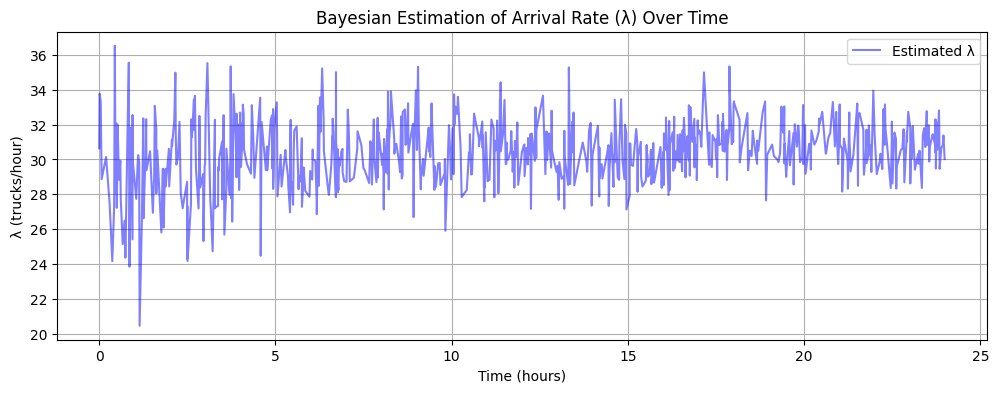

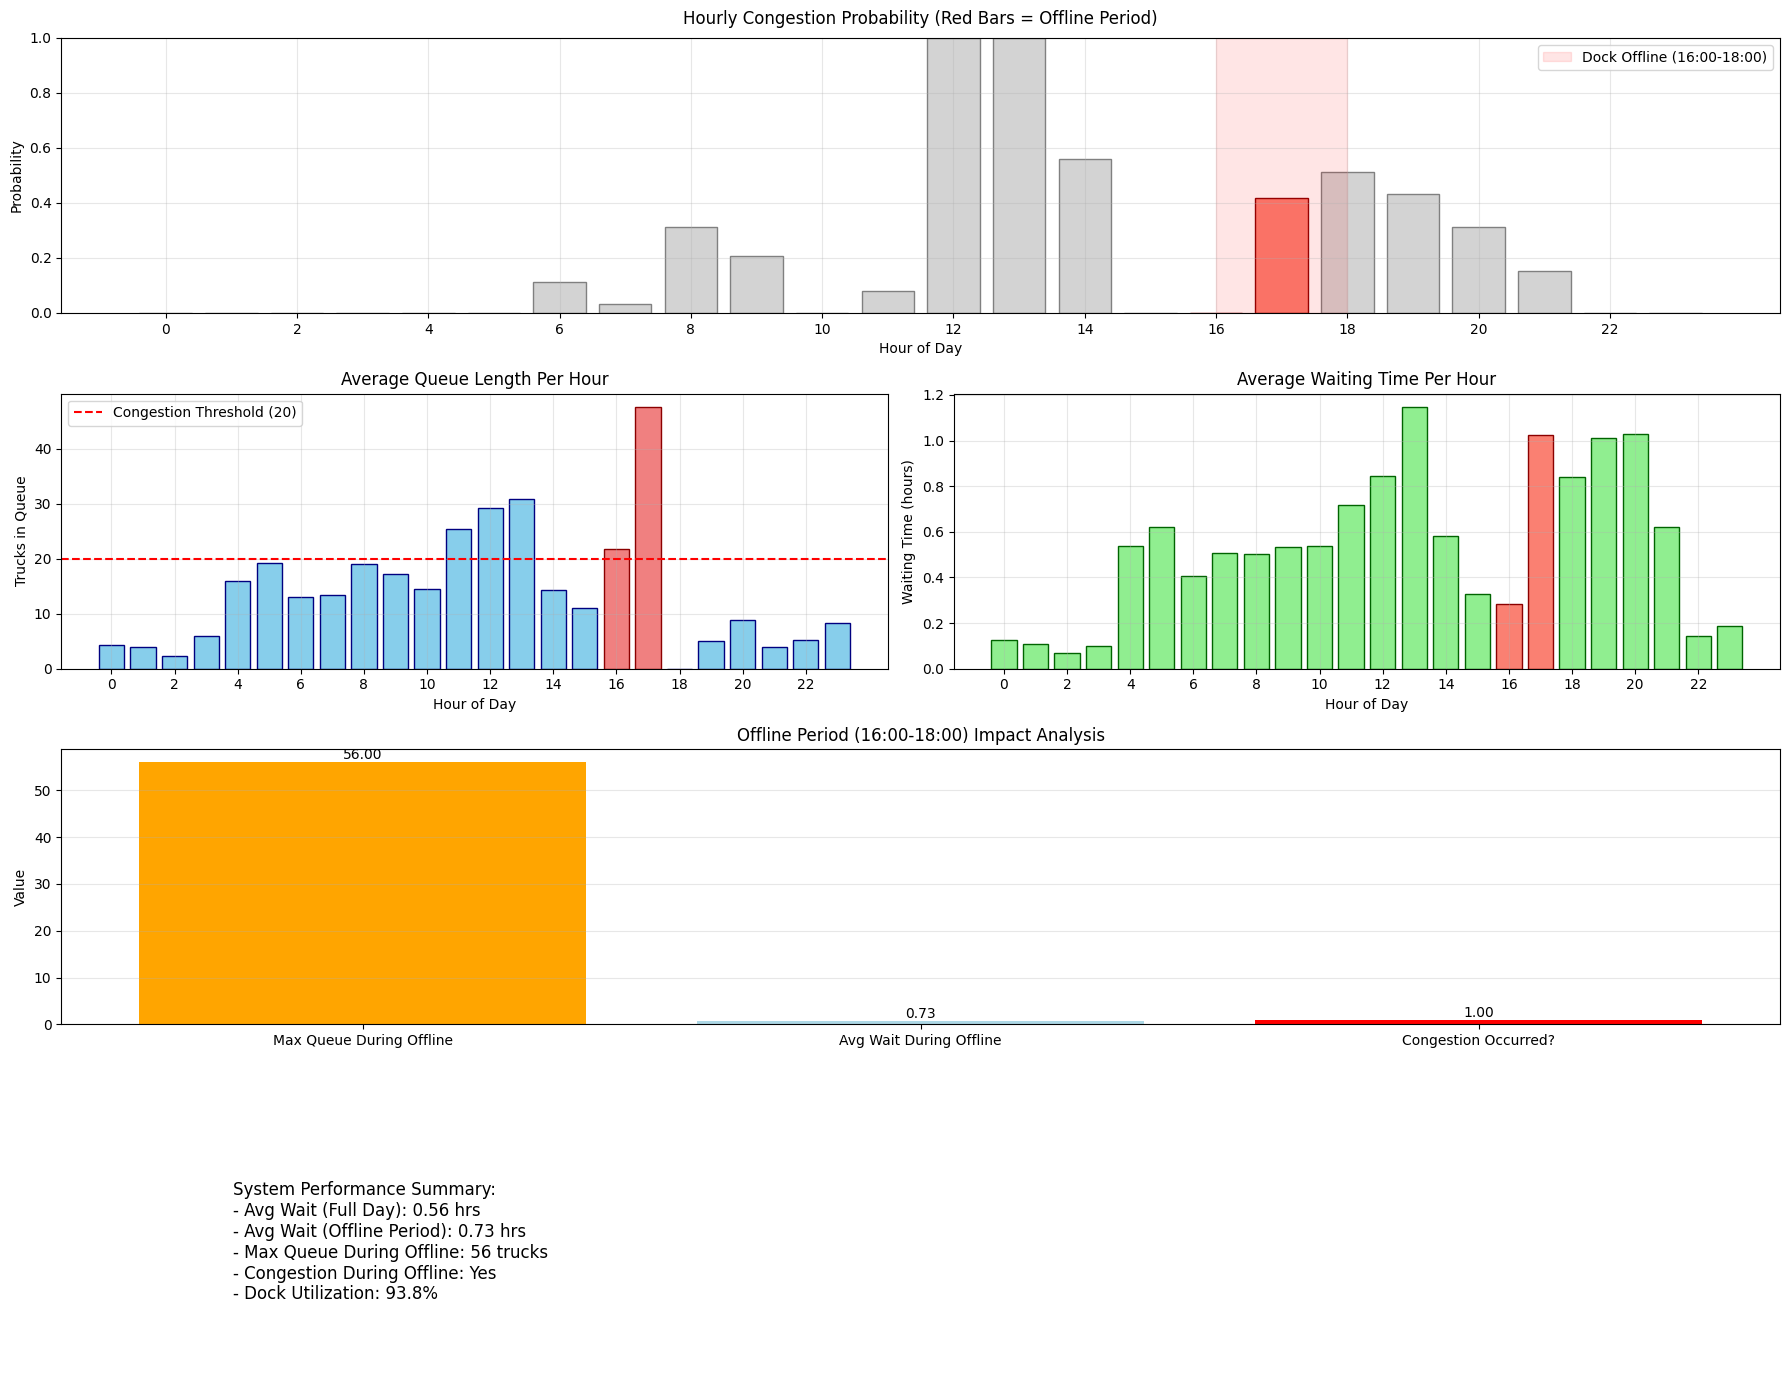

In [ ]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.gridspec import GridSpec

class DynamicDocks:
    """Wrapper for dynamic dock capacity"""
    def __init__(self, env, initial_capacity):
        self.env = env
        self.capacity = initial_capacity
        self.resource = simpy.Resource(env, capacity=initial_capacity)

    def change_capacity(self, new_capacity):
        """Create a new resource with updated capacity"""
        self.capacity = new_capacity
        self.resource = simpy.Resource(self.env, capacity=new_capacity)
        return self.resource

class PortSimulator:
    def __init__(self, config):
        self.env = simpy.Environment()
        self.config = config
        self.metrics = {
            'wait_times': [],
            'queue_lengths': [],
            'hourly_congestion': [0] * 24,
            'hourly_counts': [0] * 24,
            'hourly_wait_times': [[] for _ in range(24)],
            'utilization_time': 0.0,
            'last_event': 0.0,
            'congestion_hours': set(),
            'interarrival_times': [],
            'active_docks': config['dock_capacity'],
            'capacity_changes': [(0, config['dock_capacity'])],
            'estimated_lambda': [],
            'hourly_busy': [[] for _ in range(24)],
            'docks_offline': 0,
            'offline_effects': {
                'max_queue_during_offline': 0,
                'avg_wait_during_offline': 0,
                'congestion_occurred': False
            }
        }
        self.docks = DynamicDocks(self.env, config['dock_capacity'])
        self.alpha = 60
        self.beta = 2
        self.last_arrival_time = 0
        self.env.process(self.manage_dock_schedule())

    def manage_dock_schedule(self):
        """Manage dock capacity changes including offline period"""
        # Take 1 dock offline at 4 PM (hour 16)
        yield self.env.timeout(16)
        new_capacity = max(1, self.docks.capacity - 1)
        self.docks.change_capacity(new_capacity)
        self.metrics['active_docks'] = new_capacity
        self.metrics['docks_offline'] = 1
        self.metrics['capacity_changes'].append((self.env.now, new_capacity))
        print(f"\nDock capacity reduced to {new_capacity} at hour {self.env.now} (4 PM)")

        # Restore dock at 6 PM (hour 18)
        yield self.env.timeout(2)
        new_capacity = min(self.config['dock_capacity'], self.docks.capacity + 1)
        self.docks.change_capacity(new_capacity)
        self.metrics['active_docks'] = new_capacity
        self.metrics['docks_offline'] = 0
        self.metrics['capacity_changes'].append((self.env.now, new_capacity))
        print(f"Dock capacity restored to {new_capacity} at hour {self.env.now} (6 PM)")

    def truck_handler(self, truck_id):
        arrival = self.env.now
        with self.docks.resource.request() as req:
            # Enhanced queue tracking
            queue_length = len(self.docks.resource.queue)
            self.metrics['queue_lengths'].append((self.env.now, queue_length))

            # Track max queue during offline period
            if 16 <= self.env.now < 18:
                self.metrics['offline_effects']['max_queue_during_offline'] = max(
                    self.metrics['offline_effects']['max_queue_during_offline'],
                    queue_length
                )

            yield req

            current_hour = int(self.env.now)
            if current_hour >= 24:
                return

            wait = self.env.now - arrival
            self.metrics['wait_times'].append(wait)
            self.metrics['hourly_wait_times'][current_hour].append(wait)
            self.metrics['hourly_counts'][current_hour] += 1

            # Track wait times during offline period
            if 16 <= current_hour < 18:
                offline_waits = [w for w in self.metrics['hourly_wait_times'][current_hour]]
                if offline_waits:
                    self.metrics['offline_effects']['avg_wait_during_offline'] = np.mean(offline_waits)

            busy_docks = self.docks.resource.count
            self.metrics['hourly_busy'][current_hour].append(busy_docks)
            self._update_utilization()

            if queue_length > self.config['congestion_threshold']:
                self.metrics['hourly_congestion'][current_hour] += 1
                self.metrics['congestion_hours'].add(current_hour)
                if 16 <= current_hour < 18:
                    self.metrics['offline_effects']['congestion_occurred'] = True

            service_time = np.random.exponential(1 / self.config['service_rate'])
            yield self.env.timeout(service_time)
            self._update_utilization()

    def _update_utilization(self):
        """Track dock utilization over time"""
        now = self.env.now
        elapsed = now - self.metrics['last_event']
        busy_docks = self.docks.resource.count
        self.metrics['utilization_time'] += elapsed * busy_docks
        self.metrics['last_event'] = now

    def calculate_utilization(self):
        """Calculate accurate utilization percentage"""
        total_dock_hours = 0
        last_time = 0
        last_capacity = self.config['dock_capacity']

        for time, new_capacity in self.metrics['capacity_changes']:
            total_dock_hours += (time - last_time) * last_capacity
            last_time = time
            last_capacity = new_capacity

        total_dock_hours += (24 - last_time) * last_capacity
        return self.metrics['utilization_time'] / total_dock_hours

    def generate_arrivals(self):
        """Generate trucks using Bayesian-estimated λ"""
        while self.env.now < 24:
            current_lambda = np.random.gamma(self.alpha, 1/self.beta)
            self.metrics['estimated_lambda'].append((self.env.now, current_lambda))

            interarrival = np.random.exponential(1 / current_lambda)
            yield self.env.timeout(interarrival)

            if self.last_arrival_time > 0:
                time_since_last = self.env.now - self.last_arrival_time
                self.alpha += 1
                self.beta += time_since_last

            self.last_arrival_time = self.env.now
            truck_id = len(self.metrics['wait_times'])
            self.env.process(self.truck_handler(truck_id))

    def run_simulation(self):
        """Run the simulation for 24 hours"""
        self.env.process(self.generate_arrivals())
        self.env.run(until=24)
        self._verify_utilization()

        # Calculate final average wait during offline period
        offline_waits = []
        for h in range(16, 18):
            offline_waits.extend(self.metrics['hourly_wait_times'][h])
        if offline_waits:
            self.metrics['offline_effects']['avg_wait_during_offline'] = np.mean(offline_waits)

        return self.metrics

    def _verify_utilization(self):
        """Sanity check utilization calculations"""
        hourly_util = []
        for hour in range(24):
            if not self.metrics['hourly_busy'][hour]:
                hourly_util.append(0)
                continue

            capacity = next((cap for t,cap in reversed(self.metrics['capacity_changes']) if t <= hour),
                          self.config['dock_capacity'])

            avg_busy = np.mean(self.metrics['hourly_busy'][hour])
            hourly_util.append(avg_busy / capacity)

        print("\nUtilization Verification:")
        print(f"- Hourly averages: {hourly_util}")
        print(f"- Calculated utilization: {self.calculate_utilization():.1%}")

def visualize_all_results(metrics, config):
    plt.figure(figsize=(18, 14))
    gs = GridSpec(4, 2, figure=plt.gcf())

    # Plot 1: Enhanced Congestion Probability with Offline Impact
    ax1 = plt.subplot(gs[0, :])
    hours = range(24)
    congestion_probs = [
        metrics['hourly_congestion'][h] / max(1, metrics['hourly_counts'][h])
        for h in hours
    ]

    bars = ax1.bar(hours, congestion_probs, color='lightgray', edgecolor='gray')
    for h in range(16, 18):
        bars[h].set_color('salmon')
        bars[h].set_edgecolor('darkred')

    ax1.axvspan(16, 18, color='red', alpha=0.1, label='Dock Offline (16:00-18:00)')
    ax1.set_title('Hourly Congestion Probability (Red Bars = Offline Period)', fontsize=12, pad=10)
    ax1.set_xlabel('Hour of Day', fontsize=10)
    ax1.set_ylabel('Probability', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 2))
    ax1.set_ylim(0, 1)
    ax1.legend()

    # Plot 2: Average Queue Length Per Hour (BAR CHART)
    ax2 = plt.subplot(gs[1, 0])
    hourly_queue_lengths = defaultdict(list)
    for time, length in metrics['queue_lengths']:
        hour = int(time)
        if hour < 24:
            hourly_queue_lengths[hour].append(length)

    avg_lengths = [np.mean(hourly_queue_lengths[h]) if h in hourly_queue_lengths else 0
                  for h in range(24)]

    bars = ax2.bar(hours, avg_lengths, color='skyblue', edgecolor='navy')
    # Highlight offline period bars
    for h in range(16, 18):
        bars[h].set_color('lightcoral')
        bars[h].set_edgecolor('darkred')

    ax2.axhline(y=config['congestion_threshold'], color='r', linestyle='--',
               label=f'Congestion Threshold ({config["congestion_threshold"]})')
    ax2.set_title('Average Queue Length Per Hour', fontsize=12)
    ax2.set_xlabel('Hour of Day', fontsize=10)
    ax2.set_ylabel('Trucks in Queue', fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 24, 2))

    # Plot 3: Average Waiting Time Per Hour (BAR CHART)
    ax3 = plt.subplot(gs[1, 1])
    avg_waits = [np.mean(metrics['hourly_wait_times'][h]) if metrics['hourly_wait_times'][h] else 0
                for h in hours]

    bars = ax3.bar(hours, avg_waits, color='lightgreen', edgecolor='darkgreen')
    # Highlight offline period bars
    for h in range(16, 18):
        bars[h].set_color('salmon')
        bars[h].set_edgecolor('darkred')

    ax3.set_title('Average Waiting Time Per Hour', fontsize=12)
    ax3.set_xlabel('Hour of Day', fontsize=10)
    ax3.set_ylabel('Waiting Time (hours)', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(range(0, 24, 2))

    # Plot 4: Offline Period Analysis
    ax4 = plt.subplot(gs[2, :])
    offline_data = [
        metrics['offline_effects']['max_queue_during_offline'],
        metrics['offline_effects']['avg_wait_during_offline'],
        1 if metrics['offline_effects']['congestion_occurred'] else 0
    ]
    labels = ['Max Queue During Offline', 'Avg Wait During Offline', 'Congestion Occurred?']
    colors = ['orange', 'lightblue', 'red' if offline_data[2] else 'green']

    bars = ax4.bar(labels, offline_data, color=colors)
    ax4.set_title('Offline Period (16:00-18:00) Impact Analysis', fontsize=12)
    ax4.set_ylabel('Value')
    ax4.grid(True, axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    # Plot 5: Summary with Offline Metrics
    ax5 = plt.subplot(gs[3, :])
    offline_metrics = metrics['offline_effects']
    summary_text = (
        f"System Performance Summary:\n"
        f"- Avg Wait (Full Day): {np.mean(metrics['wait_times']):.2f} hrs\n"
        f"- Avg Wait (Offline Period): {offline_metrics['avg_wait_during_offline']:.2f} hrs\n"
        f"- Max Queue During Offline: {offline_metrics['max_queue_during_offline']} trucks\n"
        f"- Congestion During Offline: {'Yes' if offline_metrics['congestion_occurred'] else 'No'}\n"
        f"- Dock Utilization: {metrics['utilization_time']/(config['dock_capacity']*24):.1%}"
    )
    ax5.text(0.1, 0.5, summary_text, fontsize=12, va='center')
    ax5.axis('off')

    plt.tight_layout()
    plt.show()

def plot_bayesian_results(metrics):
    """Plot time-varying λ estimates"""
    plt.figure(figsize=(12, 4))
    times, lambdas = zip(*metrics['estimated_lambda'])
    plt.plot(times, lambdas, 'b-', alpha=0.5, label='Estimated λ')
    plt.title('Bayesian Estimation of Arrival Rate (λ) Over Time')
    plt.xlabel('Time (hours)')
    plt.ylabel('λ (trucks/hour)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulation configuration
config = {
    'service_rate': 10,
    'dock_capacity': 3,
    'congestion_threshold': 20
}

print("Running 24-hour port simulation with dock offline period (16:00-18:00)...")
simulator = PortSimulator(config)
metrics = simulator.run_simulation()

print("\n=== Offline Period Impact Report ===")
print(f"Maximum queue during offline period: {metrics['offline_effects']['max_queue_during_offline']}")
print(f"Average wait during offline period: {metrics['offline_effects']['avg_wait_during_offline']:.2f} hours")
print(f"Congestion occurred during offline: {'YES' if metrics['offline_effects']['congestion_occurred'] else 'NO'}")

print("\nKey Metrics:")
print(f"Average wait time: {np.mean(metrics['wait_times']):.2f} hours")
print(f"Dock utilization: {simulator.calculate_utilization():.1%}")
print(f"Overall congestion probability: {sum(metrics['hourly_congestion']) / sum(metrics['hourly_counts']):.1%}")
print(f"Congestion occurred in these hours: {sorted(metrics['congestion_hours'])}")

print("\nFinal Bayesian Estimate:")
print(f"- Posterior: Gamma(α={simulator.alpha:.1f}, β={simulator.beta:.1f})")
print(f"- Mean λ: {simulator.alpha / simulator.beta:.2f} trucks/hour")

# Visualizations
plot_bayesian_results(metrics)
visualize_all_results(metrics, config)